# Installing Packages

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save model data.

In [ ]:
os.makedirs('test_dir', exist_ok=True)

In [ ]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


# Model 2: Image Augmentation

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


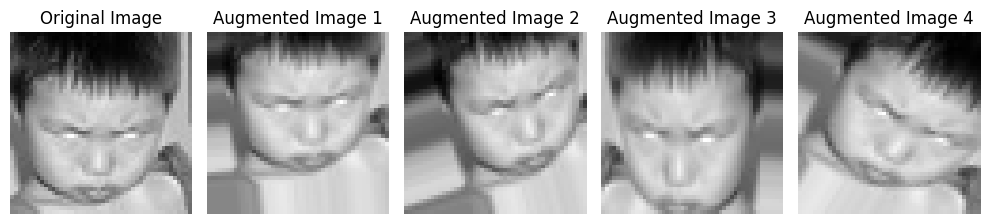

In [ ]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Same CNN Model as above

In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 12.4896 - accuracy: 0.2188
Epoch 1: val_loss improved from inf to 14.14767, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 37s 87ms/step - loss: 12.4896 - accuracy: 0.2188 - val_loss: 14.1477 - val_accuracy: 0.1681 - lr: 1.0000e-04
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 10.2419 - accuracy: 0.2406
Epoch 2: val_loss improved from 14.14767 to 10.43937, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 32s 90ms/step - loss: 10.2419 - accuracy: 0.2406 - val_loss: 10.4394 - val_accuracy: 0.2284 - lr: 1.0000e-04
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 8.1725 - accuracy: 0.2461
Epoch 3: val_loss improved from 10.43937 to 7.88726, saving model to /co

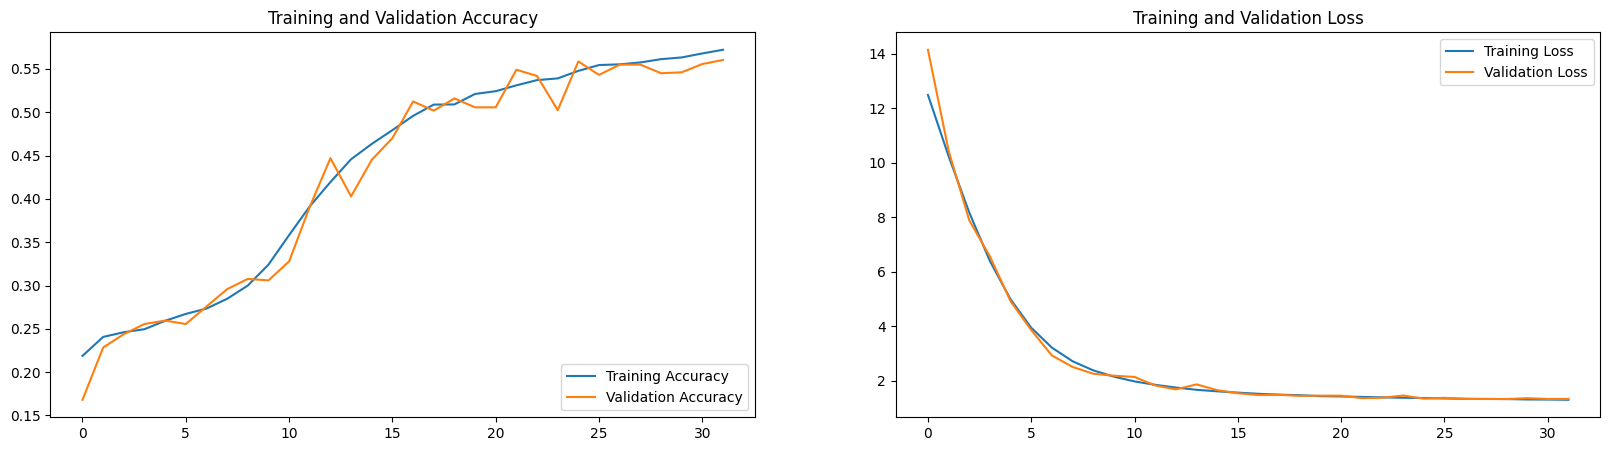

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 24ms/step - loss: 1.2292 - accuracy: 0.5928
final train accuracy = 57.64 , validation accuracy = 59.28


113/113 [==============================] - 3s 22ms/step


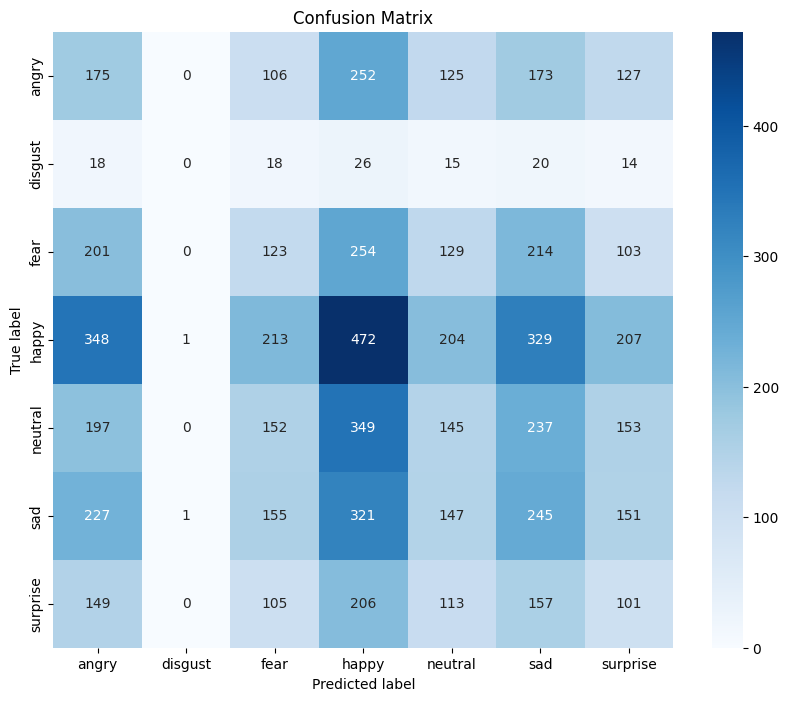

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.04      0.06       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.03      0.05      1024
       happy       0.25      0.23      0.24      1774
     neutral       0.17      0.23      0.19      1233
         sad       0.18      0.35      0.24      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.14      0.15      0.13      7178
weighted avg       0.17      0.18      0.16      7178



### Model with Image Augmentation Done